# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
from enum import Enum, auto

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

class Activations(Enum):# Клас, що визначає типи активацій, які можна використовувати в нейронній мережі.
# softmax і sigmoid — це різні способи обробки виходу нейронів, щоб перетворити числа в зрозумілі для нас значення (наприклад, ймовірності).
  softmax = auto()# Тип активації 'softmax', що автоматично отримує значення.
  sigmoid = auto()# Тип активації 'sigmoid', що автоматично отримує значення.

activation_funcs = {  # Словник, що зберігає функції активацій. (це спосіб зберегти зв'язок між типом активації і самою функцією:)
    # Activations.softmax відповідає функції tf.nn.softmax, яка перетворює числа в ймовірності, що сукупно дорівнюють 1.
    Activations.softmax: tf.nn.softmax,  # Ключ 'softmax' відповідає функції tf.nn.softmax.
    # Activations.sigmoid відповідає функції tf.nn.sigmoid, яка стискає значення в діапазон від 0 до 1.
    Activations.sigmoid: tf.nn.sigmoid,  # Ключ 'sigmoid' відповідає функції tf.nn.sigmoid.
}

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()  # Завантажуємо тренувальні і тестові дані.

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.# Ділимо всі значення пікселів на 255, щоб привести їх до діапазону від 0 до 1.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))# Створюємо об'єкт даних TensorFlow з тренувальних даних.
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)# Повторюємо, перемішуємо дані, ділимо їх на пакети (batch) та завантажуємо наперед для прискорення.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module): # Клас для створення щільного шару нейронної мережі.
    def __init__(self, in_features, out_features, name=None): # Ініціалізація класу.
        super().__init__(name=name) # Виклик конструктора базового класу з можливістю задати ім'я шару.
        self.w = tf.Variable(# Створення змінної ваги шару.
            tf.random.normal([in_features, out_features]), name="w" # Ваги ініціалізуються випадковими числами.
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")# Створення змінної зсувів (усі нулі).

    def __call__(self, x, activation=0):# Функція, викликана при застосуванні шару до даних x.
        y = tf.matmul(x, self.w) + self.b# Обчислення лінійної комбінації входів з вагами та додавання зсувів.
        if activation != 0: # Якщо активація задана (не дорівнює нулю).
            return tf.nn.softmax(y) # Застосувати softmax (використовується для класифікації).
        else: # Якщо активація не задана (рівна нулю).
            return tf.nn.sigmoid(y) # Застосувати сигмоїду (використовується для ймовірностей).

class NN(tf.Module):# Клас, створює нейронну мережу, яка складається з трьох шарів.
  def __init__(self, name=None):# Ініціалізація класу.(це конструктор, який створює три шари нейронної мережі)
    super().__init__(name=name) # Викликаємо базовий клас з можливістю задати ім'я.
    # Перший шар, який складається з 128 нейронів. Він приймає вхідні дані і обробляє їх.
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1, name="DL1")
    # Другий шар, який складається з 256 нейронів. Він отримує дані від першого шару і далі їх обробляє.
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2, name="DL2")
    # Вихідний шар. Він видає остаточний результат, наприклад, якусь передбачену категорію або клас.
    self.layer_3 = DenseLayer(in_features=n_hidden_2, out_features=num_classes, name="EL")



  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer_1(x)
    x = self.layer_2(x)
    return self.layer_3(x, activation=Activations.softmax)

In [5]:
# В якості функції помилки (loss) в даному випадку зручно взяти крос-ентропію
# Функція для обчислення крос-ентропії — міри того, наскільки передбачення моделі далекі від реальних значень.
# Використовується для вимірювання, наскільки передбачення моделі відрізняються від правильних відповідей. Це допомагає зрозуміти, наскільки добре модель навчається.
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector(Спочатку ми перетворюємо правильні відповіді в "one hot" вектор — спеціальний формат, де правильний клас позначається 1, а всі інші — 0.)
    y_true_h = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes, dtype=tf.float32) # Перетворюємо правильні значення y_true в "one hot" вектори.
    # print(f"cross_entropy {y_true=}")

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.cast(y_pred, tf.float32) # Перетворюємо передбачення моделі y_pred в формат float32.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.0) # Обмежуємо значення передбачень, щоб уникнути помилок при обчисленні логарифму.
    #print(f"{y_true_h.shape=}")
    #print(f"{y_pred.shape=}")
    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true_h * tf.math.log(y_pred))) # Обчислюємо середнє значення крос-ентропії для оцінки точності моделі.

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):  # Функція для обчислення точності передбачення моделі.(Вимірює, наскільки часто модель правильно передбачає клас.)
    # Convert predicted probabilities to predicted labels/Перетворення прогнозованих ймовірностей на прогнозовані мітки
    #print(f"{y_pred=}")
    y_pred_labels = tf.argmax(y_pred, axis=1) # Знаходимо індекси з максимальними значеннями у передбаченнях y_pred, які є найбільш ймовірними класами.

    # Compare predicted labels with true labels/Порівняйте прогнозовані мітки з істинними
    y_true = tf.cast(y_true, tf.float32)# Перетворюємо правильні значення y_true в формат float32.
    y_pred_labels = tf.cast(y_pred_labels, tf.float32)# Перетворюємо передбачені значення y_pred_labels в формат float32.
    correct_predictions = tf.equal(y_pred_labels, y_true) # Порівнюємо передбачені значення з реальними і визначаємо, які передбачення були правильними.

    # Compute accuracy/Точність обчислень
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))# Обчислюємо точність як середнє значення правильних передбачень.

    return accuracy# Повертаємо значення точності.

In [6]:
# Функція навчання нейромережі, змінює ваги нейромережі, щоб вона краще вгадувала правильні відповіді на основі наданих прикладів.
def train(model, input_x, output_y, learning_rate=learning_rate): # Це функція, яка навчає нейромережу використовувати дані (input_x) і правильні відповіді (output_y).
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  # (Градієнтний спуск: Це метод, який допомагає знайти найкращі значення для ваг, щоб мінімізувати помилку.)
  optimizer = tf.optimizers.Adam(learning_rate)  # Вибираємо метод для налаштування вагів нейромережі. У даному випадку — це метод "Adam".

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g: # Ми використовуємо спеціальний інструмент (GradientTape), щоб запам'ятати, як ми обчислюємо втрати (loss) для нейромережі.
    pred = model(input_x) # Робимо передбачення за допомогою моделі на основі вхідних даних.
    loss = cross_entropy(pred, output_y) # Обчислюємо, наскільки передбачення моделі відрізняються від правильних відповідей (це називається втрата).

  # Отримаємо градієнти відносно ваг
  gradients = g.gradient(loss, model.trainable_variables)  # Обчислюємо градієнти (як зміни ваг впливають на втрати).

  # Оновлення ваг за допомогою градієнтного спуску
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))  # Оновлюємо ваги моделі, щоб зменшити втрати.

  # # Модифікуємо параметри
  # model.trainable_variables[0].assign_sub(learning_rate * gradients[0])
  # model.trainable_variables[1].assign_sub(learning_rate * gradients[1])

  # Або одна команда:
  #optimizer.minimize(loss, model.trainable_variables)  # Ця команда може замінити два рядки вище та автоматично оновлює ваги, мінімізуючи втрати.
  return loss # Повертаємо значення втрати, щоб побачити, наскільки добре модель навчилася.
  # Обчислення втрати: Втрата показує, наскільки передбачення моделі відрізняються від правильних відповідей.
  # Ми використовуємо її для того, щоб знати, чи потрібно змінювати ваги в нейромережі.

# Тренування

In [7]:
# Створимо екземпляр нейронної мережі для тренування.
neural_net = NN(name="mnist") # Створюємо нову нейронну мережу з ім'ям "mnist".

# Тренування мережі
loss_history = []  # Список для збереження значень втрат (loss) кожні display_step кроків.
accuracy_history = []  # Список для збереження точності (accuracy) кожні display_step кроків.

# У цьому циклі ми будемо проводити навчання нейронної мережі із тренувального датасета train_data вилучи випадкову підмножину,
# на якій відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
# Ми зберігаємо втрати і точність моделі на кожному кроці, щоб потім можна було проаналізувати результати.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):# Проходимо через дані, які ми тренуємо, по частинам (пакетам).
    # Оновлюємо ваги нейронної мережі - Тренуємо модель на нових даних.
    # print(batch_x)
    # print(f"{batch_y.dtype=}")
    train(neural_net, batch_x, batch_y, learning_rate=0.002) # Тренуємо модель на нових даних.
    if step % display_step == 0: # Кожні display_step кроків:
        pred = neural_net(batch_x) # Отримуємо передбачення моделі.
        # print(batch_y.shape)
        # print(pred.shape)
        current_loss = cross_entropy(pred, batch_y) # Обчислюємо поточні втрати.
        acc = accuracy(pred, batch_y)  # Обчислюємо точність моделі.
        accuracy_history.append(acc)  # Додаємо точність до списку.
        loss_history.append(current_loss) # Додаємо втрати до списку.
        print(f"Step {step:4}, Loss: {current_loss:7.2f}, Accuracy: {acc:.2%}")  # Виводимо крок, втрати і точність.
        if acc > 0.99: # Якщо точність перевищує 99%:
          print("Break by accuracy") # Виводимо повідомлення про досягнення високої точності.
          break # Завершуємо навчання.

Step  100, Loss:  218.59, Accuracy: 75.78%
Step  200, Loss:  111.35, Accuracy: 88.28%
Step  300, Loss:  115.09, Accuracy: 87.89%
Step  400, Loss:   84.26, Accuracy: 91.80%
Step  500, Loss:   92.20, Accuracy: 90.62%
Step  600, Loss:   53.36, Accuracy: 95.31%
Step  700, Loss:   54.09, Accuracy: 92.58%
Step  800, Loss:   76.00, Accuracy: 93.75%
Step  900, Loss:   30.44, Accuracy: 96.48%
Step 1000, Loss:   23.64, Accuracy: 97.66%
Step 1100, Loss:   22.48, Accuracy: 96.88%
Step 1200, Loss:    7.35, Accuracy: 98.83%
Step 1300, Loss:   31.13, Accuracy: 96.48%
Step 1400, Loss:   30.60, Accuracy: 96.48%
Step 1500, Loss:   32.94, Accuracy: 98.05%
Step 1600, Loss:   18.62, Accuracy: 98.83%
Step 1700, Loss:   12.28, Accuracy: 98.05%
Step 1800, Loss:   39.91, Accuracy: 97.27%
Step 1900, Loss:   28.90, Accuracy: 94.53%
Step 2000, Loss:   18.12, Accuracy: 97.66%
Step 2100, Loss:   31.75, Accuracy: 98.05%
Step 2200, Loss:   16.13, Accuracy: 98.05%
Step 2300, Loss:   40.37, Accuracy: 96.48%
Step 2400, 

# Візуалізація моделі

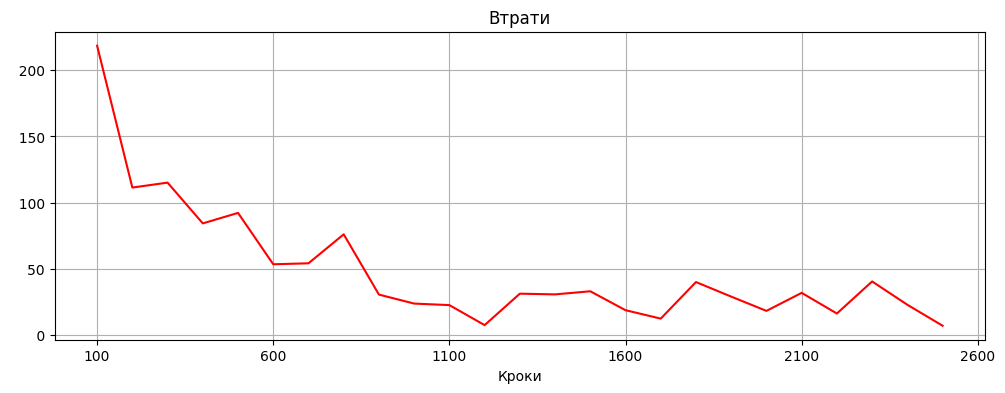

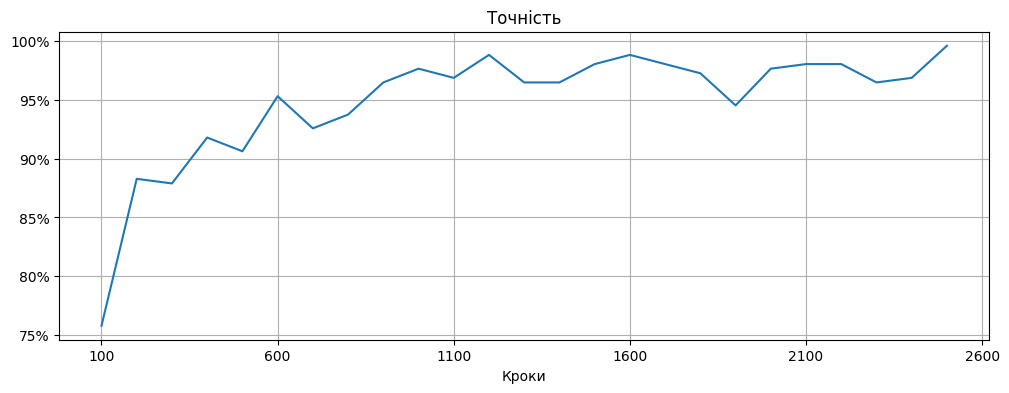

In [8]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,4)) # Створюємо нову фігуру для графіків з розмірами 12x4 дюйми.

# Виведіть графік функції втрат
plt.plot(loss_history, "r")# Будуємо графік втрат (loss) червоним кольором.
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int((x + 1) * display_step)))# Форматування осі X, щоб показувати кроки.
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y):5}'))# Форматування осі Y, щоб показувати значення втрат.
plt.xlabel("Кроки")
plt.title("Втрати")
plt.grid()

# Виведіть графік точності
fig = plt.figure(figsize=(12,4))
plt.plot(accuracy_history)# Будуємо графік точності (accuracy).
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int((x + 1) * display_step)))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))# Форматування осі Y, щоб показувати точність у відсотках.
plt.title("Точність")
plt.xlabel("Кроки")
plt.grid()
plt.show()

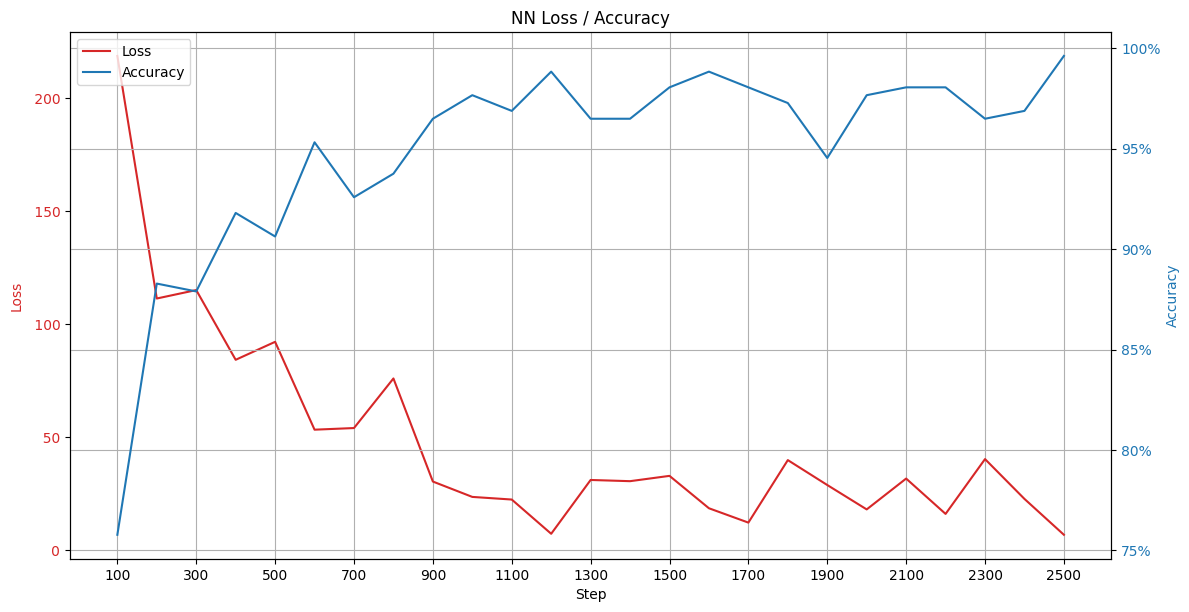

In [9]:
# Ми створюємо графік з однією основною віссю ax1 і додатковою віссю ax2 для відображення точності.
# Графік втрат: Показує, як змінюються втрати по ходу навчання нейромережі.
# Графік точності: Показує, як змінюється точність моделі.

fig, ax1 = plt.subplots() # Створюємо графік з однією осю.
fig.set_size_inches((12,6))

color = 'tab:red'  # Вибираємо червоний колір для втрат.
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss', color=color)
ax1.plot(loss_history, color=color, label="Loss")
ax1.tick_params(axis='y', labelcolor=color)# Налаштовуємо кольори підписів осі Y.
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int((x + 1) * display_step)))
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y):4}'))
ax1.set_xticks(np.arange(0, len(loss_history)+1, step=2))  # Set label locations.
#ax1.legend()


ax2 = ax1.twinx()  # Створюємо другу вісь Y, яка поділяє ту ж ось X.

color = 'tab:blue'  # Вибираємо синій колір для точності.
ax2.set_ylabel('Accuracy', color=color)
p2=ax2.plot(accuracy_history, color=color, label="Accuracy")# Будуємо графік точності синім кольором.
ax2.tick_params(axis='y', labelcolor=color)  # Налаштовуємо кольори підписів осі Y.
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}')) # Форматування осі Y для точності.
#ax2.legend() #  якщо потрібно показати легенду.

#ax1.grid()  # Увімкнення сітки на осі X.
ax2.grid() # Увімкнення сітки на осі Y для точності.
ax1.xaxis.grid(True) # Увімкнення сітки на осі X.

# Об'єднуємо легенди з обох осей ax1 and ax2
lines, labels = ax1.get_legend_handles_labels()  # Отримуємо легенду з першої осі.
lines2, labels2 = ax2.get_legend_handles_labels() # Отримуємо легенду з другої осі.
ax2.legend(lines + lines2, labels + labels2, loc='best') # Додаємо легенду до графіка.

fig.tight_layout()  # Налаштовуємо відступи, щоб все відображалось коректно. (в іншому випадку права y-мітка злегка обрізана)
plt.title("NN Loss / Accuracy")
plt.show()

# Точність

In [10]:
# Обчисліть точність навченої нейромережі
# Обчислюємо середню точність з усіх значень, які ми зберігали під час навчання.
# Тестування моделі: Перевіряємо, як добре модель працює на нових даних, які вона не бачила раніше.
# Передбачення класів: Визначаємо, до якого класу належить кожен тестовий зразок.

acc_mean = np.mean(accuracy_history)  # Обчислюємо середню точність з усіх кроків навчання
print(f"{acc_mean=:%}") # Виводимо середню точність у відсотках

# Тестування моделі на тестових даних
test_pred = neural_net(x_test)# Отримуємо передбачення моделі для тестових даних
test_acc = accuracy(test_pred, y_test).numpy()# Обчислюємо точність на тестових даних
test_pred_values = np.argmax(test_pred, axis=1)  # Знаходимо найбільші ймовірності для передбачених класів
print(f"{test_acc=:%}") # Виводимо точність на тестових даних у відсотках

acc_mean=94.890624%
test_acc=94.709998%


In [11]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# Тестування моделі на 10 зображеннях
testing_select = 10 # Кількість зображень для тестування
test_pred_10 = neural_net(x_test[:testing_select]) # Отримуємо передбачення моделі для перших 10 зображень
test_acc_10 = accuracy(test_pred_10, y_test[:testing_select]).numpy()  # Обчислюємо точність на цих зображеннях
print(f"{testing_select=}, {test_acc_10=:.2%}")  # Виводимо точність у відсотках

# Тестування моделі на випадкових зображеннях
img_selected = 5  # Кількість випадкових зображень для тестування
sub_tests = 100  # Кількість підходів для тестування
acc_list = []  # Список для збереження точностей

# Тестуємо модель 100 разів
for i in range(sub_tests):
  random_img_idx = np.random.randint(0, x_test.shape[0], size=img_selected) # Вибираємо випадкові індекси зображень
  pred = neural_net(x_test[random_img_idx]) # Отримуємо передбачення моделі для цих зображень
  acc = accuracy(pred, y_test[random_img_idx]).numpy() # Обчислюємо точність для цих зображень
  acc_list.append(acc)  # Додаємо точність у список

mean_acc = np.mean(acc_list) # Обчислюємо середню точність
print(f"{sub_tests=} by {img_selected}: {mean_acc=:.2%}") # Виводимо середню точність у відсотках
print(f"selected imnage idx: {random_img_idx}")  # Виводимо індекси вибраних зображень
print("test_values:", y_test[random_img_idx]) # Виводимо правильні значення для вибраних зображень

# Отримуємо передбачення для останнього вибору зображень
pred_values = np.argmax(pred, axis=1)  # Знаходимо класи з найбільшими ймовірностями
print("pred_values:", pred_values) # Виводимо передбачені класи
print(f"accuraccy : {acc:.2%}")   # Виводимо точність для останніх зображень

# Тестування на 10 зображеннях: Перевіряємо, як добре модель працює на перших 10 зображеннях з тестової вибірки.
# Випадкові зображення: Випадковим чином вибираємо 5 зображень і тестуємо їх 100 разів, щоб перевірити, як часто модель помиляється.
# Точність: Обчислюємо середню точність моделі на випадкових зображеннях.

testing_select=10, test_acc_10=90.00%
sub_tests=100 by 5: mean_acc=96.40%
selected imnage idx: [6208  410 9711 6897 6136]
test_values: [7 7 7 8 5]
pred_values: [7 7 7 8 5]
accuraccy : 100.00%


In [12]:
# Створюємо імена для кожного класу, щоб мати зрозумілий вигляд у звіті.
# Показуємо, як добре модель класифікує різні цифри.
# Виводимо точність моделі, яка показує, скільки відсотків зображень були правильно класифіковані.

# Створюємо список з назвами класів для звіту
target_names = [ f"Number: {i}" for i in range(0, num_classes)] # Формуємо список назв для кожної цифри від 0 до num_classes
# Виводимо звіт по класифікації
print(classification_report(y_test, test_pred_values, target_names=target_names)) # Друкуємо звіт про те, як модель класифікує кожен клас

# Отримуємо звіт по класифікації у форматі словника
cr = classification_report(y_test, test_pred_values, target_names=target_names, output_dict=True) # Додаємо звіт у форматі словника для подальшого використання
# Виводимо точність (accuracy) з звіту
print(cr["accuracy"])  # Друкуємо точність моделі, отриману з звіту

              precision    recall  f1-score   support

   Number: 0       0.96      0.98      0.97       980
   Number: 1       0.99      0.97      0.98      1135
   Number: 2       0.94      0.95      0.95      1032
   Number: 3       0.94      0.92      0.93      1010
   Number: 4       0.96      0.95      0.95       982
   Number: 5       0.93      0.93      0.93       892
   Number: 6       0.96      0.96      0.96       958
   Number: 7       0.96      0.93      0.94      1028
   Number: 8       0.88      0.95      0.91       974
   Number: 9       0.95      0.93      0.94      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

0.9471


In [13]:
# Створюємо матрицю плутанини
# Матриця плутанини: Це таблиця, яка показує, скільки разів модель правильно або неправильно класифікувала кожен клас.
cm = confusion_matrix(y_test, test_pred_values, labels=range(10))  # Рахуємо помилки моделі, порівнюючи справжні та передбачені значення
cm # Друкуємо матрицю, щоб побачити, де модель робить помилки і які цифри класифікує правильно.

array([[ 960,    0,    3,    1,    1,    1,    5,    1,    6,    2],
       [   0, 1103,    5,    0,    0,    5,    3,    3,   15,    1],
       [   6,    2,  981,    7,    0,    1,    4,   10,   21,    0],
       [   4,    1,   14,  934,    0,   23,    0,    7,   22,    5],
       [   2,    0,    5,    1,  928,    2,   12,    5,    8,   19],
       [   7,    0,    2,   15,    4,  829,    9,    2,   22,    2],
       [   8,    2,    6,    0,    5,   12,  919,    0,    5,    1],
       [   2,    6,   21,   10,    8,    3,    0,  957,    5,   16],
       [   5,    0,    3,   17,    4,   13,    4,    5,  921,    2],
       [   5,    3,    3,    8,   18,    2,    0,   11,   20,  939]])

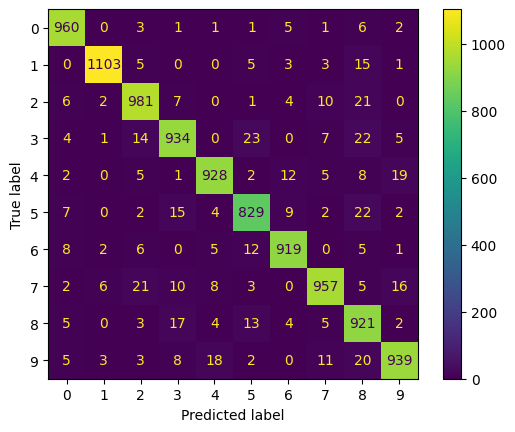

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay # ConfusionMatrixDisplay: Це спеціальний інструмент, який допомагає візуалізувати матрицю плутанини у вигляді графіка.

# from_predictions: Функція, яка створює графік на основі справжніх і передбачених значень.
# Створюємо і показуємо графік матриці плутанини
ConfusionMatrixDisplay.from_predictions(y_test, test_pred_values  )
plt.show()

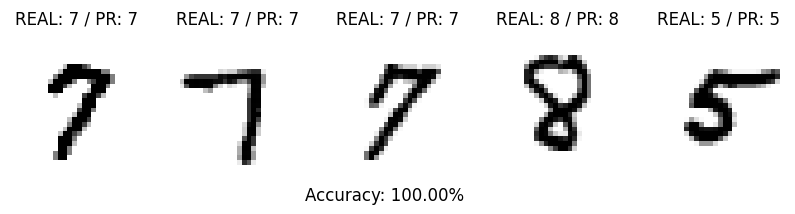

In [15]:

# Визначаємо кольори для зображень. Білий для правильних відповідей, червоний для неправильних
# Створюємо список кольорів для графіка
colors = [(1, 1, 1), (1, 0, 0), (1, 0, 0)]  # білий, червоний, червоний
custom_cmap = plt.cm.colors.LinearSegmentedColormap.from_list("CustomRed", colors, N=256)

plt.figure(figsize=(10, 5))
img_size = int(x_test.shape[1]**(1/2)) # Визначаємо розмір зображення

# Для кожного з вибраних зображень
for i, idx in enumerate(random_img_idx, start=1):
    plt.subplot(1, img_selected, i) # Створюємо підграфік (додаємо зображення на графік)
    correct = y_test[idx] == pred_values[i-1] # Перевіряємо правильність передбачення
    cmap = 'gray_r' if correct else custom_cmap # Вибираємо колір: сірий для правильних, червоний для неправильних
    color = "black" if correct else "red" # Колір заголовка: чорний для правильних, червоний для неправильних
    plt.imshow(x_test[idx].reshape(img_size, img_size), cmap=cmap)  # Відображаємо зображення
    plt.title(f'REAL: {y_test[idx]} / PR: {pred_values[i-1]}', color=color)# Додаємо заголовок
    plt.axis('off')  # Приховуємо осі

plt.suptitle(f"Accuracy: {acc:.2%}")  # Додаємо заголовок для всього графіка
plt.subplots_adjust(top=2.2) # Налаштовуємо відступи
plt.show()

In [16]:
# Виводимо середню похибку на тестових зображеннях
print(f"При тестуванні {x_test.shape[0]} тестових зображень середня похибка склала: {1-cr['accuracy']:.2%}")
# Виводимо середню похибку на вибірці з певної кількості зображень
print(f"На вибірці з {img_selected} зображень на {sub_tests} тестуваннях середня похибка склала: {1-mean_acc:.2%}")

При тестуванні 10000 тестових зображень середня похибка склала: 5.29%
На вибірці з 5 зображень на 100 тестуваннях середня похибка склала: 3.60%


# Висновок


Точність моделі: 94.71%. Це означає, що модель правильно класифікує 94.71% зображень.

Як модель класифікує цифри:

Модель добре справляється з цифрами 0, 1 і 6, з точністю близько 97%, 98% і 96% відповідно.

Найгірше модель класифікує цифри 3, 5 і 8, з точністю 93%, 93% і 91% відповідно.

Загальна точність: В середньому, модель правильно класифікує 95% зображень.


При тестуванні 10000 зображень: середня похибка склала 5.29%. Це показує, як добре модель справляється з великою кількістю даних.
На вибірці з 5 зображень, протестованих 100 разів: середня похибка склала 3.60%. Це може показувати, як модель працює на маленьких вибірках і може мати меншу похибку у таких випадках.